
# Getting started

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [2]:
import numpy as np
import pandas as pd
import patsy

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV

import statsmodels.formula.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
iowa = pd.read_csv('../../Iowa_Sample.csv')

iowa.head(1)

## Load the data into a DataFrame and take a look 

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38


In [5]:
## converting to datatime format 

iowa['Date'] = pd.to_datetime(iowa.Date)


In [6]:
#renaming columns 

iowa_cols = ['date', 'store_num', 'city', 'zip', 'county_num', 'county','category', 'category_name','vendor_num','item_num','item_description','bottle_vol','st_cost','st_rev','bot_sold','sale','vol_lit','vol_gal']
iowa.columns = iowa_cols 

#removing dollar signs and converting to float

iowa['st_cost']=(iowa['st_cost'].replace( '[\$,)]','', regex=True ).astype('float'))
iowa['st_rev']=(iowa['st_rev'].replace( '[\$,)]','', regex=True ).astype('float'))
iowa['sale']=(iowa['sale'].replace( '[\$,)]','', regex=True ).astype('float'))

#creating profit column
iowa['st_prof'] = iowa['st_rev']-iowa['st_cost']


In [8]:
#creating second data frame of stores 
iowa_stores = pd.read_csv('../../Iowa_Liquor_Stores.csv')

iowa_stores.head()

,Store,Name,Store Status,Address,City,State,Zip Code,Store Address,Report Date
0,3816,Swils,A,200 E Oak St,Red Oak,IA,51566,"200 E Oak St\nRed Oak, IA 51566\n(41.016691, -...",12/01/2016
1,5194,Shelby General Store,A,"406, East St",Shelby,IA,51570,"406, East St\nShelby, IA 51570\n(41.515195, -9...",12/01/2016
2,2106,Hillstreet News and Tobacco,A,2217 College,Cedar Falls,IA,50613,"2217 College\nCedar Falls, IA 50613\n(42.51718...",12/01/2016
3,2113,Jamboree Foods,A,1119 Market St. Box 71,Gowrie,IA,50543,"1119 Market St. Box 71\nGowrie, IA 50543\n(42....",12/01/2016
4,2130,Sycamore Convenience,A,617 Sycamore,Waterloo,IA,50703,"617 Sycamore\nWaterloo, IA 50703\n(42.497804, ...",12/01/2016


In [9]:
#creating a dictionary of store names and zip codes to add to iowa data frame
store_names = iowa_stores.set_index('Store').to_dict()['Name']

def store_nam(x):
    try:
        return store_names[x]
    except:
        return 'unknown'

iowa['store_names'] = iowa['store_num'].apply(store_nam)

iowa.head()

,date,store_num,city,zip,county_num,county,category,category_name,vendor_num,item_num,item_description,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,vol_gal,st_prof,store_names
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38,2.25,The Liquor Stop / Sumner
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40,6.88,Hy-Vee #3 Food and Drugstore
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34,6.30,Hillstreet News and Tobacco
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77,4.75,Hy-Vee #2 / Ames
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55,3.60,The Beverage Shop / Belmond


In [61]:
#loading in GPS data

jview4 = pd.read_csv('../jview.csv')

jview4.head(2)


,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,INV-01099500003,10/20/2016,5205.0,Glidden Grocery,201 Idaho St,Glidden,51443,"201 Idaho St\nGlidden 51443\n(42.056889, -94.7...",14.0,CARROLL,...,77900.0,Smirnoff Sours Berry Lemon,12.0,750.0,$8.25,$12.38,1.0,$12.38,0.75,0.19
1,INV-01099500002,10/20/2016,5205.0,Glidden Grocery,201 Idaho St,Glidden,51443,"201 Idaho St\nGlidden 51443\n(42.056889, -94.7...",14.0,CARROLL,...,11776.0,Black Velvet,12.0,750.0,$5.23,$7.85,1.0,$94.20,0.75,0.19


In [10]:
import calendar
import datetime

#setting up a month column
iowa['month'] = iowa['date'].apply(lambda x: x.strftime('%b'))

iowa.head()

,date,store_num,city,zip,county_num,county,category,category_name,vendor_num,item_num,...,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,vol_gal,st_prof,store_names,month
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,...,750,4.50,6.75,12,81.00,9.0,2.38,2.25,The Liquor Stop / Sumner,Nov
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,...,750,13.75,20.63,2,41.26,1.5,0.40,6.88,Hy-Vee #3 Food and Drugstore,Mar
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,...,1000,12.59,18.89,24,453.36,24.0,6.34,6.30,Hillstreet News and Tobacco,Feb
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,...,1750,9.50,14.25,6,85.50,10.5,2.77,4.75,Hy-Vee #2 / Ames,Feb
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,...,1750,7.20,10.80,12,129.60,21.0,5.55,3.60,The Beverage Shop / Belmond,Aug


## After inspectiing the null data I've decided to drop the cells - There doesn't seem to be a consistent bias in the missing data so it's most effective to drop versus trying to impute values. 

In [11]:
iowa[iowa.county.isnull()] 
iowa[iowa.county_num.isnull()] 
iowa[iowa.category.isnull()]
iowa.isnull().sum()

iowa = iowa.dropna()


In [25]:
##function to set liquor categories 

def get_category(column):
    if "WHISKIES" in column:
        return 'whiskey'
    elif "VODKA" in column:
        return 'vodka'
    elif "RUM" in column:
        return 'rum'
    elif "TEQUILA" in column:
        return 'tequila'
    else:
        return 'other'

In [26]:
#apllying function 

iowa['category'] = iowa['category_name'].apply(get_category)

In [28]:
iowa.head(1)

,date,store_num,city,zip,county_num,county,category,category_name,vendor_num,item_num,...,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,vol_gal,st_prof,store_names,month
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,other,APRICOT BRANDIES,55,54436,...,750,4.5,6.75,12,81.0,9.0,2.38,2.25,The Liquor Stop / Sumner,Nov


In [30]:
# dropping unecessary columns for my analysis 

iowa.drop(['county_num','category_name','vendor_num','item_num','st_prof','vol_gal'],axis=1,inplace=True)

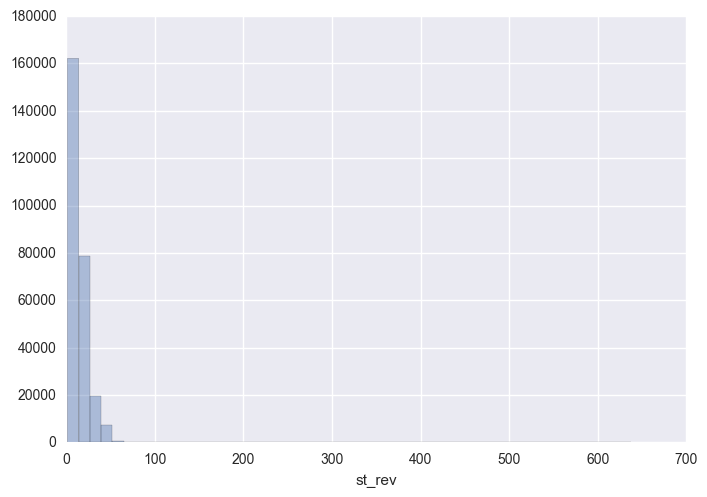

In [32]:
sns.distplot(iowa.st_rev, kde=False)
plt.show()

#looks to be some stores that are outliers 

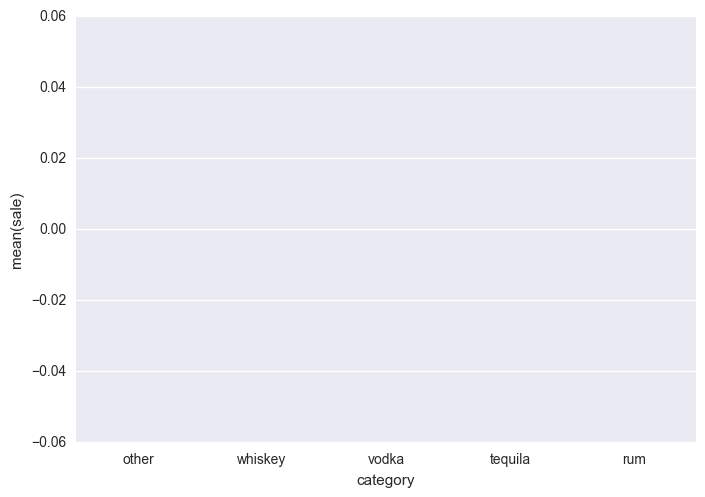

In [39]:
###state makes the most total on tequilla sales 
sns.barplot(x = 'category', y = iowa.groupby('category').sale.sum(), data = iowa)
plt.show()

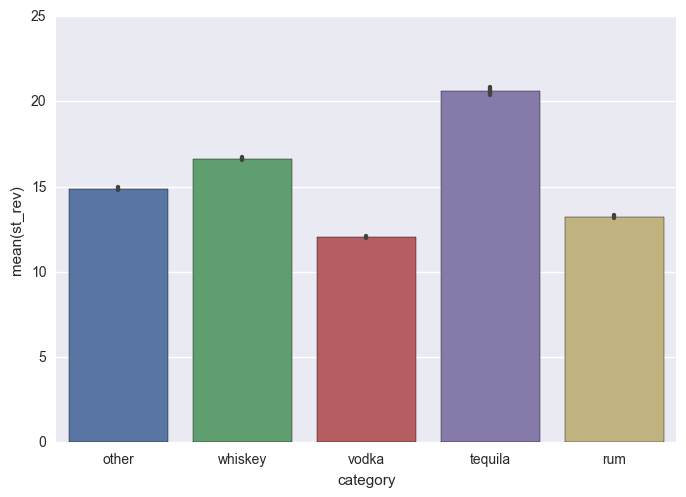

In [36]:
###state makes the most per sale on tequilla sales 

sns.barplot(x = 'category', y = 'st_rev', data = iowa)
plt.show()

In [244]:
##looking at dates. 

iowa.sort('date')

#First date = 01/05/2015 
#Last date = 03/31/2016

#reminder - add in extra days for modeling months 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,date,store_num,city,zip,county,category,item_description,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,store_names,month
152861,2015-01-05,4491,CEDAR RAPIDS,52403,Linn,vodka,Hawkeye Vodka,1750,7.17,10.76,6,64.56,10.50,Casey's General Store #2772 / Cedar Rapids,Jan
195000,2015-01-05,4910,WATERLOO,50702,Black Hawk,rum,Captain Morgan Spiced Rum,1000,11.75,17.63,12,211.56,12.00,Prime Mart #3 / Waterloo,Jan
185399,2015-01-05,2643,WATERLOO,50701,Black Hawk,other,Jack Daniel's SB Ducks Unlimited w/Btl Stopper,750,27.09,40.64,6,243.84,4.50,Hy-Vee Wine and Spirits / Waterloo,Jan
105690,2015-01-05,4967,BLUE GRASS,52726,Scott,whiskey,Black Velvet Toasted Caramel Mini,600,4.96,7.44,1,7.44,0.60,Jeff's Market / Blue Grass,Jan
268891,2015-01-05,4284,IOWA FALLS,50126,Hardin,other,Dekuyper Luscious Peachtree Schnapps,750,6.30,9.45,12,113.40,9.00,Fareway Stores #559 / Iowa Falls,Jan
169876,2015-01-05,2613,COUNCIL BLUFFS,51501,Pottawattamie,other,Dr. Mcgillicuddy's Mint Schnapps,375,5.33,8.00,2,16.00,0.75,Hy-Vee Food Store #1 / Council Bluffs,Jan
163001,2015-01-05,2573,MUSCATINE,52761,Muscatine,other,E & J Xo Brandy,750,8.00,12.00,3,36.00,2.25,Hy-Vee Food Store / Muscatine,Jan
191204,2015-01-05,4543,MARION,52302,Linn,whiskey,Kessler Blend Whiskey,750,5.51,8.27,12,99.24,9.00,Casey's General Store #2924 / Marion,Jan
100549,2015-01-05,2560,MARION,52302,Linn,vodka,Absolut Apeach,750,11.49,17.24,6,103.44,4.50,Hy-Vee Food Store / Marion,Jan
230231,2015-01-05,4126,SOLON,52333,Johnson,vodka,Smirnoff Vodka 80 Prf Pet,1750,14.75,22.13,6,132.78,10.50,Sam's Mainstreet Market / Solon,Jan


In [253]:
#1378 stores 

iowa['store_num'].nunique()

In [ ]:
iowa['whiskey_sales'] = iowa[iowa.category == 'whiskey'] 

In [14]:
#grouping data into time periods 
q1_2015 = iowa[(iowa['date'] <= '2015-03-31')]
q2_2015 = iowa[(iowa['date'] >= '2015-04-01') & (iowa['date'] <= '2015-12-31')]
q1_2016 = iowa[(iowa['date'] >= '2016-01-01')]



In [277]:
q2_2015.head()
#sns.barplot(x=iowa_2015_q1.sale.sum(),y=iowa_2016_q1.sale.sum())
#plt.show()

,date,store_num,city,zip,county,category,item_description,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,store_names,month
0,2015-11-04,3717,SUMNER,50674,Bremer,other,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.00,The Liquor Stop / Sumner,Nov
4,2015-08-18,3654,BELMOND,50421,Wright,vodka,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.00,The Beverage Shop / Belmond,Aug
5,2015-04-20,2569,CEDAR RAPIDS,52402,Linn,other,New Amsterdam Gin,1750,13.32,19.98,6,119.88,10.50,Hy-Vee Food Store #2 / Cedar Rapids,Apr
6,2015-08-05,2596,OTTUMWA,52501,Wapello,other,Korbel Brandy,750,6.66,9.99,3,29.97,2.25,Hy-Vee / Regal Liquors and Video,Aug
7,2015-06-25,3456,CLEAR LAKE,50428,Cerro Gordo,whiskey,Canadian Club Whisky,1750,15.75,23.63,2,47.26,3.50,Quick Shop / Clear Lake,Jun


In [259]:
iowa4 = iowa.groupby(['store_num',"month"],axis=0).category.value_counts().reset_index(level=1)
iowa4.head()

month  category
store_num category                
2106      vodka      Apr        16
          other      Apr        14
          whiskey    Apr        10
          rum        Apr         2
          tequila    Apr         2

,store_num,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit
0,2106,595600,6722.95,10092.37,12573,176517.45,11836.10
1,2113,175625,1994.22,2993.26,830,11376.12,836.85
2,2130,475375,5083.25,7627.72,9144,139440.02,8436.27
3,2152,169875,1372.80,2065.50,670,8625.74,720.87
4,2178,302875,2833.94,4257.50,2408,29912.68,2437.92


In [33]:
st_iowa_cat = iowa.groupby(['store_num'],axis=0).sum().reset_index(level=1)


In [15]:
#grouping by store for different time periods 
st_q1_15 = q1_2015.groupby(['store_num'],axis=0).sum().reset_index(level=1)
st_q2_15 = q2_2015.groupby(['store_num'],axis=0).sum().reset_index(level=1)
st_q1_16 = q2_2015.groupby(['store_num'],axis=0).sum().reset_index(level=1)


st_q2_15.head()

,store_num,county_num,vendor_num,item_num,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,vol_gal,st_prof
0,2106,2779.0,107155,23949173,363250,4121.80,6187.11,7650,106751.41,7193.75,1900.75,2065.31
1,2113,9870.0,23938,4482309,103250,1155.03,1733.91,475,6476.97,482.74,127.49,578.88
2,2130,2128.0,78840,15441754,280400,2948.04,4423.72,5885,87311.34,5432.12,1435.15,1475.68
3,2152,1853.0,26099,4407555,114500,899.70,1354.41,419,5717.62,481.63,127.20,454.71
4,2178,567.0,43252,8423591,194375,1825.30,2742.48,1438,18467.77,1507.31,398.22,917.18


In [321]:
st_q1_15['store_num'] = st_q1_15.astype('int')
st_q2_15['store_num'] = st_q2_15.astype('int')
st_q1_16['store_num'] = st_q1_16.astype('int')

In [62]:
#creating a list of indices 

rmx = []
for i in range(1260,1338):
    rmx.append(i)
#rmx

In [36]:
drop_array = np.asarray(rmx)

In [64]:
#78 missing rows 
#dropping extra values 

st_q2_15 = st_q2_15.drop(st_q2_15.index[[drop_array]])
st_q1_16 = st_q1_16.drop(st_q1_16.index[[drop_array]])
#st_q1_16

In [322]:
#trying to create a ban field of stores that are only in one date range 

l2 = st_q2_15['store_num']
l1 = st_q1_15['store_num']

st_list = []
for x in l1:
    if x not in l2:
        st_list.append(x)
    else:
        pass
len(st_list)

l3 = list(set(l2) - set(l1))
len(l3)

ban_field = l3

In [327]:
#ban_field

In [65]:
#st_q2_15[st_q2_15['store_num'] is in ban_field].index.tolist()

In [66]:
#st_q2_15[~st_q2_15.store_num.isin(ban_field)]



In [40]:
#creating new variables 

st_q1_15['avg_bottle_price'] = st_q1_15['sale']/st_q1_15['bottle_vol']
st_q1_15['liquor_quality'] = st_q1_15['sale']/st_q1_15['vol_lit']

st_q2_15['avg_bottle_price'] = st_q2_15['sale']/st_q2_15['bottle_vol']
st_q2_15['liquor_quality'] = st_q2_15['sale']/st_q2_15['vol_lit']

st_q1_16['avg_bottle_price'] = st_q1_16['sale']/st_q1_16['bottle_vol']
st_q1_16['liquor_quality'] = st_q1_16['sale']/st_q1_16['vol_lit']


In [67]:
#  mydf.groupby(['cat', "class"], as_index=False).val.sum()

iowa2 = iowa.groupby(['store_num',"month"],axis=0).sum().reset_index(level=1)

iowa2.head(3)

,month,county_num,vendor_num,item_num,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,vol_gal,st_prof
store_num,,,,,,,,,,,,
2106,Apr,308.0,10453,2843853,40600,403.30,605.78,1077,11957.86,1036.1,273.76,202.48
2106,Aug,280.0,10845,1805621,36500,435.51,653.37,786,12329.82,732.0,193.42,217.86
2106,Dec,308.0,11922,2280137,40000,433.41,650.69,796,9665.47,738.0,194.99,217.28


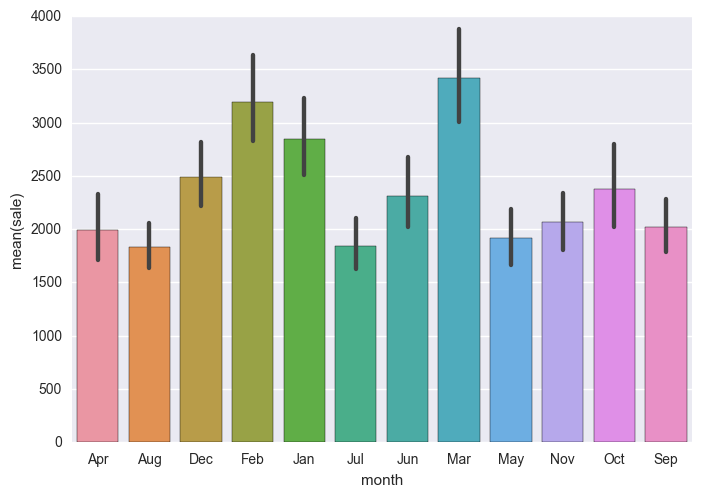

In [236]:
sns.barplot(x='month',y='sale',data=iowa2)
plt.show()

In [123]:
#creating dataframe with volume data by store  
by_store = iowa.groupby('store_num').sale.agg(['sum'])

by_store.head()

,sum
store_num,
2106,176849.97
2113,11376.12
2130,139727.54
2152,9097.51
2178,29912.68


In [124]:
##creating a dataframe by store (this was my first attempt at this - leaving it in as it's how I learned )

by_store['volume'] = iowa.groupby('store_num').vol_lit.sum()

#adding total bottles sold
by_store['bottles'] = iowa.groupby('store_num').bot_sold.sum()

by_store['avg_bot_price'] = by_store['sum']/by_store['bottles']
by_store['store_num'] = by_store.index

by_store.rename(columns={'sum':'sales'},inplace=True)

by_store.head()

,sales,volume,bottles,avg_bot_price,store_num
store_num,,,,,
2106,176849.97,11849.60,12587,14.050208,2106
2113,11376.12,836.85,830,13.706169,2113
2130,139727.54,8448.27,9156,15.260762,2130
2152,9097.51,773.50,709,12.831467,2152
2178,29912.68,2437.92,2408,12.422209,2178


In [152]:
#creating dictionaries to add to the dataframe 

store_zips = iowa.set_index('store_num').to_dict()['zip']
store_counties = iowa.set_index('store_num').to_dict()['county']

store_counties[2178]

'Allamakee'

In [153]:
#applying above 

def store_zip(x):
    return store_zips[x]

by_store['store_zip'] = by_store['store_num'].apply(store_zip)

def store_county(x):
    return store_county[x]

by_store['store_county'] = by_store['store_num'].apply(lambda x: store_counties[x])

by_store.head()


,sales,volume,bottles,avg_bot_price,store_num,store_zip,store_county
store_num,,,,,,,
2106,176849.97,11849.60,12587,14.050208,2106,50613,Black Hawk
2113,11376.12,836.85,830,13.706169,2113,50543,Webster
2130,139727.54,8448.27,9156,15.260762,2130,50703,Black Hawk
2152,9097.51,773.50,709,12.831467,2152,50469,Cerro Gordo
2178,29912.68,2437.92,2408,12.422209,2178,52172,Allamakee


In [68]:

#df['monthName'] = df['monthNumer'].apply(lambda x: calendar.month_name[x])

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

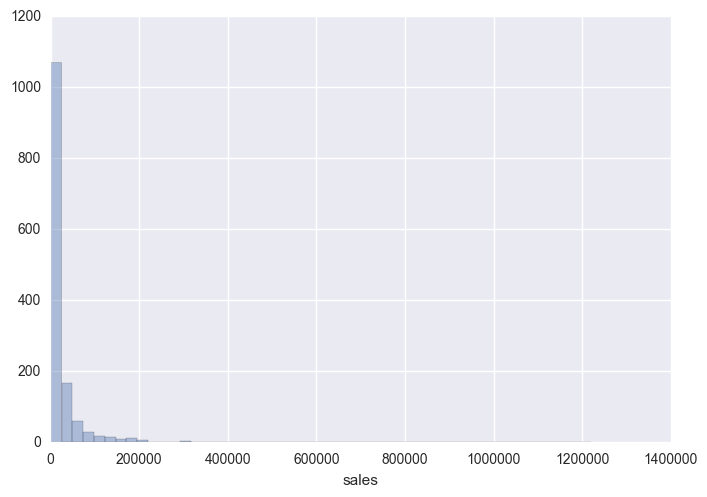

In [66]:
#there are some big time outliers for sales 

sns.distplot(by_store.sales, kde=False)
plt.show()

In [ ]:
sns.barplot(, kde=False)
plt.show()

# Record your findings

Be sure to write out anything observations from your exploratory analysis.

In [67]:
by_store[by_store.sales>500000]

,sales,volume,bottles,avg_bot_price,store_num
store_num,,,,,
2512,532265.62,33397.94,35679,14.918177,2512
2633,1220335.09,75921.50,76756,15.898889,2633
3385,506589.09,36232.50,31737,15.962098,3385
4829,1089152.87,63484.99,65719,16.572876,4829


In [68]:
#This Hy-Vee in Des Moines is a huge outlier 

iowa[iowa.store_num==2633]

,date,store_num,city,zip,county_num,county,category,category_name,vendor_num,item_num,item_description,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,vol_gal,st_prof,store_names
39,2016-03-07,2633,DES MOINES,50320,77.0,Polk,1011200.0,STRAIGHT BOURBON WHISKIES,461,22157,Wild Turkey 101,1000,16.16,24.24,12,290.88,12.00,3.17,8.08,Hy-Vee #3 / BDI / Des Moines
130,2016-03-14,2633,DES MOINES,50320,77.0,Polk,1081700.0,DISTILLED SPIRITS SPECIALTY,381,27372,American Born Moonshine Original,750,12.50,18.75,1,18.75,0.75,0.20,6.25,Hy-Vee #3 / BDI / Des Moines
137,2015-12-17,2633,DES MOINES,50320,77.0,Polk,1062200.0,PUERTO RICO & VIRGIN ISLANDS RUM,55,44217,Barton Rum Light,1000,4.00,6.00,36,216.00,36.00,9.51,2.00,Hy-Vee #3 / BDI / Des Moines
164,2015-09-10,2633,DES MOINES,50320,77.0,Polk,1031200.0,VODKA FLAVORED,380,41705,Uv Red (cherry) Vodka,1000,7.50,11.25,24,270.00,24.00,6.34,3.75,Hy-Vee #3 / BDI / Des Moines
236,2015-01-15,2633,DES MOINES,50320,77.0,Polk,1012100.0,CANADIAN WHISKIES,65,10846,Canadian Club Small Batch Classic,750,13.12,19.68,1,19.68,0.75,0.20,6.56,Hy-Vee #3 / BDI / Des Moines
351,2015-03-23,2633,DES MOINES,50320,77.0,Polk,1081700.0,DISTILLED SPIRITS SPECIALTY,421,77487,Tortilla Gold Dss,1000,4.51,6.77,240,1624.80,240.00,63.40,2.26,Hy-Vee #3 / BDI / Des Moines
369,2015-05-22,2633,DES MOINES,50320,77.0,Polk,1081390.0,IMPORTED SCHNAPPS,421,69637,Dr. Mcgillicuddy's Cherry Schnapps,1000,11.00,16.50,12,198.00,12.00,3.17,5.50,Hy-Vee #3 / BDI / Des Moines
378,2015-11-19,2633,DES MOINES,50320,77.0,Polk,1041100.0,AMERICAN DRY GINS,380,31719,Phillips Gin,1000,4.38,6.57,36,236.52,36.00,9.51,2.19,Hy-Vee #3 / BDI / Des Moines
499,2015-02-02,2633,DES MOINES,50320,77.0,Polk,1012100.0,CANADIAN WHISKIES,55,12407,Canadian Ltd Whisky,1000,5.50,8.25,12,99.00,12.00,3.17,2.75,Hy-Vee #3 / BDI / Des Moines
839,2015-11-30,2633,DES MOINES,50320,77.0,Polk,1012200.0,SCOTCH WHISKIES,260,10009,Scoresby Rare Scotch,1000,6.74,10.11,12,121.32,12.00,3.17,3.37,Hy-Vee #3 / BDI / Des Moines


# Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

 


In [285]:
st_q1_15.head()

,store_num,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,avg_bottle_price,liquor_quality
0,2106,114350,1295.36,1944.71,2705,39287.29,2526.10,0.343571,15.552547
1,2113,35875,442.94,664.49,196,2833.25,177.11,0.078976,15.997120
2,2130,83150,892.66,1339.92,1533,24272.57,1447.25,0.291913,16.771511
3,2152,35000,307.97,462.75,154,2003.46,151.74,0.057242,13.203242
4,2178,47325,471.19,707.93,490,5856.41,409.81,0.123749,14.290549


# Refine the data

Look for any statistical relationships, correlations, or other relevant properties of the dataset.

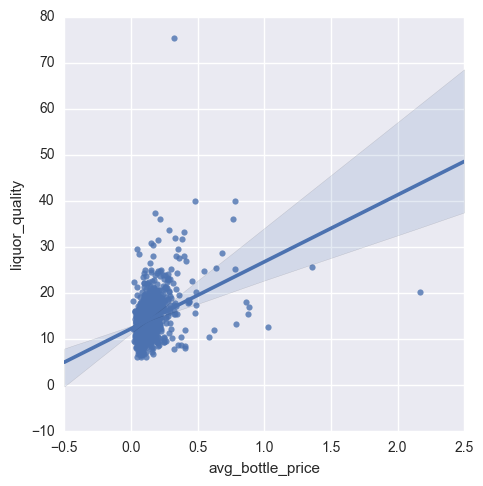

In [41]:
#linear relationship here 

sns.lmplot(x = 'avg_bottle_price', y='liquor_quality', data=st_q1_15)
plt.show()

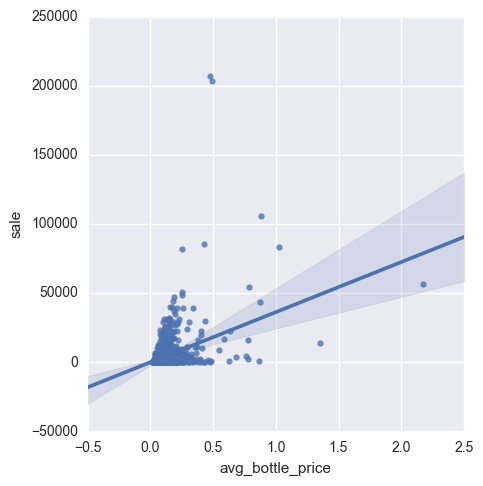

In [287]:
sns.lmplot(x = 'avg_bottle_price', y='sale', data=st_q1_15)
plt.show()

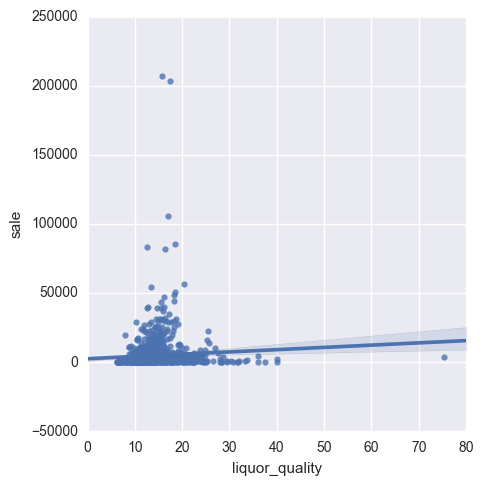

In [288]:
sns.lmplot(x = 'liquor_quality', y='sale', data=st_q1_15)
plt.show()

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [280]:
st_q1_15.head(1)


,store_num,bottle_vol,st_cost,st_rev,bot_sold,sale,vol_lit,avg_bottle_price,liquor_quality
0,2106,114350,1295.36,1944.71,2705,39287.29,2526.1,0.343571,15.552547


# For this model I'm assuming sales are correlated across months - i.e. that june 2016 sales will look like june 2015 sales. For evidence please look at the historical data at https://data.iowa.gov/Economy/Total-Liquor-Sales-in-Iowa-by-Month/xiyh-fbvw


In [292]:
#making sure my columns are the right length 

st_q1_15.store_num.nunique()


1261

In [42]:
st_q2_15.store_num.nunique()


1261

In [43]:
st_q1_16.store_num.nunique()


1261

In [44]:
#converting store type to string 
st_q1_15['store_num'] = st_q1_15.astype('str')
st_q2_15['store_num'] = st_q2_15.astype('str')
st_q1_16['store_num'] = st_q1_16.astype('str')

st_q1_15['sale_mod'] = st_q1_15['sale']*(91/86)


In [45]:
X = st_q1_15[['sale','avg_bottle_price','bot_sold']]
y = st_q2_15['sale']

In [57]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)


In [58]:
from sklearn import linear_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score




LR = LinearRegression()
LRf = LM.fit(X_train, y_train)

y_pred = LRf.predict(X_test)
r2_score(y_test, y_pred)

-0.078252361401144999

In [ ]:
#summing up values for predictions 

total = sum(y_pred)
print(total)

5,411,468

tot = st_q1_16.sale.sum()
print(tot)

2,1845,493

final_prediction = (tot+total)*10
print('final prediction:',final_prediction)

##Final prediction
272,569,624

## Final Prediction Above

In [1]:
#import statsmodels.api as sm
#model = sm.OLS(y_train,X_train).fit()


#model.summary()


# Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.